In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Es 1.1

In [61]:
img = cv2.imread('contrast2.jpeg', cv2.IMREAD_GRAYSCALE)

Looking at the histogram of the image, we can see that it's well distributed and the image has an high contrast

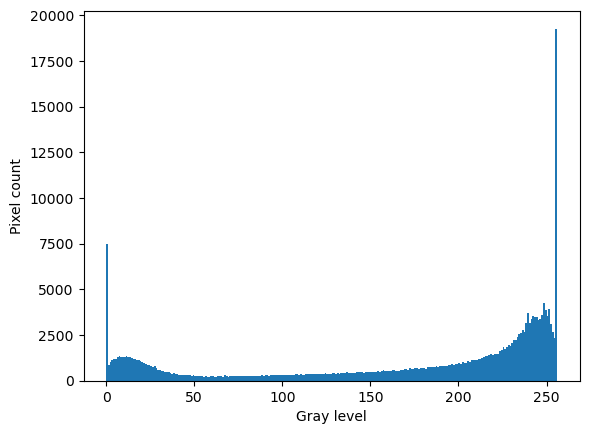

In [62]:
plt.hist(img.ravel(),256,[0,256])
plt.xlabel("Gray level")
plt.ylabel("Pixel count")
plt.show()

convertScaleAbs() applies a linear transformation to the image.
$$
\text{dst}(x,y) = \text{clip}(\alpha \cdot \text{src}(x,y) + \beta, 0, 255)
$$

Using alpha < 1 will reduce the contrast scaling the values, and beta adds a value incrementing the brightness of the image.
The resulting values are limited in the interval 0-255

In [63]:
alpha = 0.22
beta = 175
low_img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

 After the linear transformation, the histogram is much more shrunk, so we obtained the low-contrast image, also since we choose beta = 175, all the gray level are above that value.
Also the lower the alpha, the smaller is the amplitude of gray levels, so for not having too much saturation I use alpha = 0.22.

(I hope I understand well the description of the exercise here, and all the pixels should be brighter than 175).

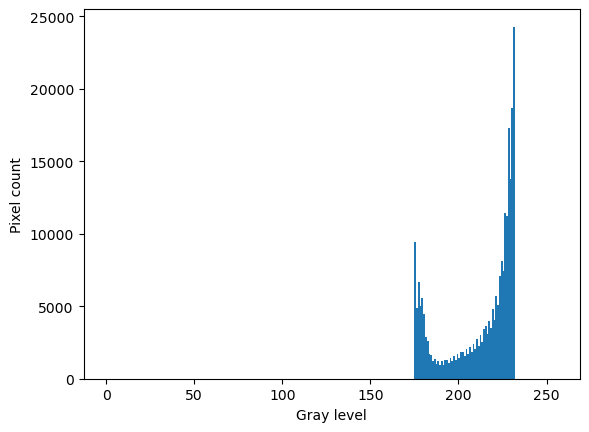

In [64]:
plt.hist(low_img.ravel(),256,[0,256])
plt.xlabel("Gray level")
plt.ylabel("Pixel count")
plt.show()

In [65]:
cv2.imshow('Image after reducing contrast',low_img)
cv2.waitKey(0)

111

Since the amplitude of gray lever is small and the intensity is high, thinking about non-linear transformation, the gamma correction is the best one for improving the contrast of the image.
Log-trasformation is useful when you want to visualize low level of intensity in a bigger dynamic range but that's not the case.

Before applying gamma we normalize in [0,1] and then multiply again for 255 to come back to the gray scale interval.

If gamma > 1 the image will be darker and the contrast is improved. The opposite with gamma < 1.

I choose gamma = 4 because the contrast was very low, but if I choose a gamma too big the image will became too dark.

In [66]:
gamma = 4
pow_img = np.power(low_img / 255.0, gamma) * 255.0
pow_img = np.uint8(pow_img)

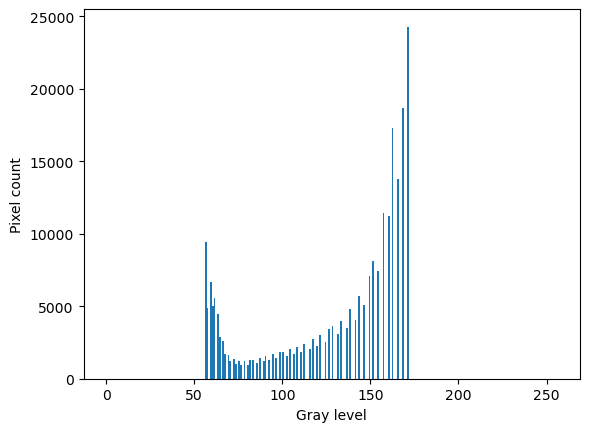

In [67]:
plt.hist(pow_img.ravel(),256,[0,256])
plt.xlabel("Gray level")
plt.ylabel("Pixel count")
plt.show()

As the histogram show, the contrast of the image is improved because we have a larger amplitude of gray levels.

In [68]:
cv2.imshow('Image after pow trasnf',pow_img)
cv2.waitKey(0)

111

Sources:
- https://medium.com/@khanhson0811/basic-intensity-transformation-functions-and-example-with-opencv-1a56932f34ac;
- https://docs.opencv.org/4.9.0/de/db2/tutorial_py_table_of_contents_histograms.html;
- https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html

# Es 1.2

In [69]:
img2_rgb = cv2.imread('landscape.jpeg')
img2 = cv2.cvtColor(img2_rgb, cv2.COLOR_RGB2GRAY)

In [70]:
import random
def transf(image, a, b):
    aleat=np.random.randint(1,101, size = (image.shape[0], image.shape[1]))
    image2 = np.where(aleat <=100*a, 0, image)
    out = np.where(aleat > 100-100*b, 255, image2)
    return out

The function 'transf' generates a matrix with the same dimension of the imput image, filled with random numbers in the interval [0,100], The pixels of the image are set to 0 if the corrisponding value of the matrix is <= 100 * a, and to 255 if is > 100 - 100 * b.

a and b are the proportion of bits set to 0 and 255 respectively. (if a = 1 all pixel are set to 0 for example).

In [71]:
I1 = transf(img2, 0.1, 0.1)
I2 = transf(img2, 0.2, 0)

In [72]:
from sklearn.metrics import mean_squared_error

mse1 = mean_squared_error(img2.flatten(), I1.flatten())
mse1

21.78671933575445

In [73]:
mse2 = mean_squared_error(img2.flatten(), I2.flatten())
mse2

21.776759313495784

The MSE of the original images and I1 and I2 is not very high, because the values of a and b for the transformation are pretty low. Changing the values i noticed that the MSE is directly proportional to the sum a+b. In the example, in both I1 and I2 a+b = 0.2 and MSE is ~20. Putting a+b = 0.5 the MSE will be ~50.

To correct the image and reduce the MSE it's possible to use filters.

The difference between the average and gaussian filter is that the former take in consideration all the pixel around uniformly, the gaussian filter assigns weights to the pixel around with a gaussian distribution.

In [74]:
filter_3 = cv2.blur(I1, (3, 3))
filter_5 = cv2.blur(I1, (5, 5))

In [75]:
mse_3x3 = mean_squared_error(img2.flatten(), filter_3.flatten())
mse_3x3

87.12521819353327

In [76]:
mse_5x5 = mean_squared_error(img2.flatten(), filter_5.flatten())
mse_5x5

81.48989720009372

In [77]:
filter_gaussian = cv2.GaussianBlur(I1, (3, 3), 0)

In [78]:
mse_gaussian = mean_squared_error(img2.flatten(), filter_gaussian.flatten())
mse_gaussian

84.44587189550141

Average and gaussian filters are not effective in this case.
Analyzing the function we can see that it introduce a salt and pepper noise, since we have random white and black dots in the image.

According to OpenCV documentation, the most effective filter for salt and pepper is the median filter. In fact, a black or white dot influences too much if we apply the average, using the median this behaviour is attenuated.

In [79]:
filter_median = cv2.medianBlur(I1,3)

In [80]:
mse_median = mean_squared_error(img2.flatten(), filter_median.flatten())
mse_median

15.187223816776008

With the median filter the mse is reduced.